In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
#from matplotlib.animation import FuncAnimation
#from matplotlib.animation import PillowWriter #save animation outside of Jupyter Notebook's environment
 
import scienceplots
plt.style.use(['science','notebook','dark_background'])

## Lorenz 1963 system (Trial System)
### Lorenz Attractor for specific parameters and initial condition: 
$$
\rho =28, \sigma = 10, \beta = 8/3 \qquad and \qquad x(0) = y(0) = z(0) = 1
$$

In [2]:
class Lorenz63:
    def __init__(self, rho=28, sigma=10, beta=8/3):
        self.rho = rho
        self.sigma = sigma
        self.beta = beta

    def derivative(self, t, Y):
        x, y, z = Y
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z
        return np.array([dxdt, dydt, dzdt])

## 4th Order Runge-Kutta (RK4) Scheme 

In [3]:
class RK4:
    def __init__(self, f, t0, y0, t_end, h):
        self.f = f
        self.t0 = t0
        self.y0 = y0
        self.t_end = t_end
        self.h = h

    def solve(self):
        t_values = [self.t0]
        y_values = [self.y0]

        t = self.t0
        y = self.y0

        while t < self.t_end:
            if t + self.h > self.t_end:
                self.h = self.t_end - t

            k1 = self.h * self.f(t, y)
            k2 = self.h * self.f(t + 1/2 * self.h, y + 1/2 * k1)
            k3 = self.h * self.f(t + 1/2 * self.h, y + 1/2 * k2)
            k4 = self.h * self.f(t + self.h, y + k3)

            y = y + 1/6 * (k1 + 2*k2 + 2*k3 + k4)
            t = t + self.h

            t_values.append(t)
            y_values.append(y)

        return np.array(t_values), np.array(y_values)

## Addaptive Runge-Kutta-Fehlberg (RKF45) Scheme

Solve an initial value problem using the Runge-Kutta-Fehlberg (RKF45) method with adaptive step size control.
    
Parameters: 
- f: function(t, y) that defines the ordinary differential equation dy/dt = f(t, y)
- t0: initial time
- y0: initial value of y at t0
- t_end: end time
- h_init: initial step size
- tol: tolerance for error control
        
Returns:
- t_values: array of time points
- y_values: array of corresponding solution values
   

In [4]:
class RKF45:
    def __init__(self, f, t0, y0, t_end, h_init, tol):
        self.f = f
        self.t0 = t0
        self.y0 = y0
        self.t_end = t_end
        self.h_init = h_init
        self.tol = tol

    def solve(self):
        t_values = [self.t0]
        y_values = [self.y0]

        t = self.t0
        y = self.y0
        h = self.h_init

        while t < self.t_end:
            if t + h > self.t_end:
                h = self.t_end - t

            k1 = h * self.f(t, y)
            k2 = h * self.f(t + 1/4 * h, y + 1/4 * k1)
            k3 = h * self.f(t + 3/8 * h, y + 3/32 * k1 + 9/32 * k2)
            k4 = h * self.f(t + 12/13 * h, y + 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3)
            k5 = h * self.f(t + h, y + 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4)
            k6 = h * self.f(t + 1/2 * h, y - 8/27 * k1 + 2 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5)

            y_4 = y + 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5
            y_5 = y + 16/135 * k1 + 6656/12825 * k3 + 28561/56430 * k4 - 9/50 * k5 + 2/55 * k6

            delta = np.abs(y_5 - y_4)

            if np.max(delta) < self.tol:
                t = t + h
                y = y_5
                t_values.append(t)
                y_values.append(y)

            if delta.all() != 0:
                h = 0.9 * h * (self.tol / np.max(delta))**0.2

        return np.array(t_values), np.array(y_values)

In [5]:
# Define parameters
rho = 28
sigma = 10
beta = 8/3
t0 = 0
t_end = 100
y0 = np.array([1, 1, 1])
h_rkf45 = 0.01
tol = 1e-6

# Create instances of Lorenz63, RK4, and RKF45
lorenz_system = Lorenz63(rho, sigma, beta)
rk4_solver = RK4(lorenz_system.derivative, t0, y0, t_end, h_rkf45)
rkf45_solver = RKF45(lorenz_system.derivative, t0, y0, t_end, h_rkf45, tol)

# Solve using RK4 and RKF45
t_values_rk4, y_values_rk4 = rk4_solver.solve()
t_values_rkf45, y_values_rkf45 = rkf45_solver.solve()

# Interpolate RK4 solution to match the time steps of RKF45 solution
interp_func = interp1d(t_values_rk4, y_values_rk4, axis=0)
y_values_rk4_interp = interp_func(t_values_rkf45)


## Plotting Runge-Kutta's solutions and their deviation

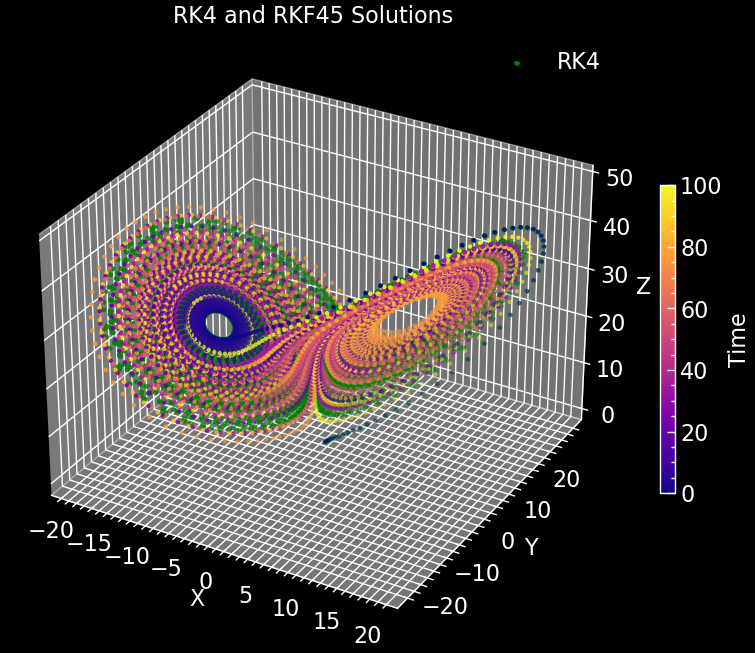

In [6]:
# Plot the solutions on the same axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Lorenz attractor as a wireframe
x = np.linspace(-20, 20, 400)
y = np.linspace(-30, 30, 600)
X, Y = np.meshgrid(x, y)
Z = (sigma*(Y-X))
#ax.plot_wireframe(X, Y, Z, color='gray', alpha=0.5)


# Plot RK4 solution in green with dashed linestyle
rk4_scatter = ax.scatter(y_values_rk4_interp[:, 0], y_values_rk4_interp[:, 1], y_values_rk4_interp[:, 2], c='green', s=10, label='RK4', linestyle='dashed')

# Plot RKF45 solution with color based on time
rkf45_scatter = ax.scatter(y_values_rkf45[:, 0], y_values_rkf45[:, 1], y_values_rkf45[:, 2], c=t_values_rkf45, cmap='plasma', s=5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('RK4 and RKF45 Solutions')
ax.legend()

# Add colorbar
cbar = fig.colorbar(rkf45_scatter, ax=ax, shrink=0.5)
cbar.set_label('Time')
cbar.ax.yaxis.set_label_position('right')
plt.show()

## Deviation Analysis

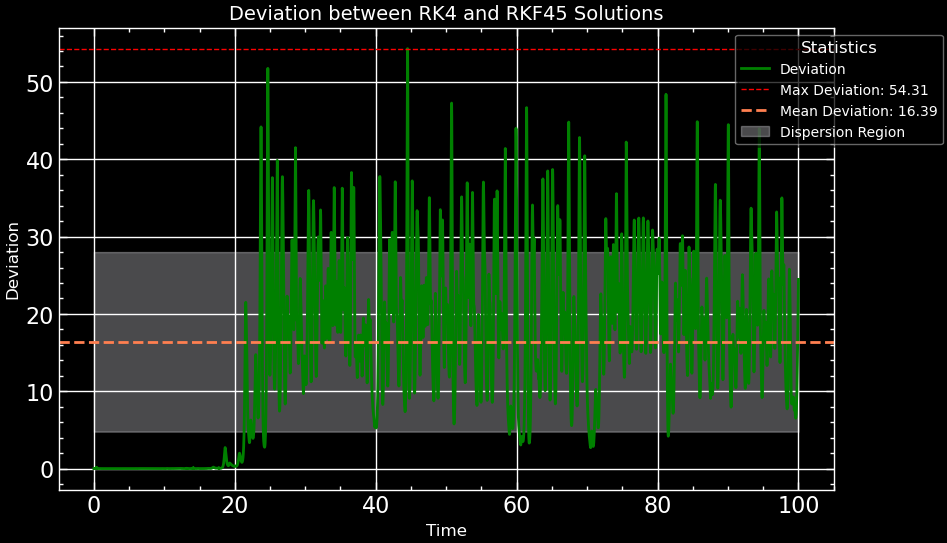

In [7]:
# Calculate deviation between RK4 and RKF45 solutions
deviation = np.linalg.norm(y_values_rk4_interp - y_values_rkf45, axis=1)

# Calculate statistics
max_deviation = np.max(deviation)
mean_deviation = np.mean(deviation)
std_deviation = np.std(deviation)

import matplotlib.patches as mpatches
# Plot deviation between RK4 and RKF45 solutions
plt.figure(figsize=(10, 6))
plt.plot(t_values_rkf45, deviation, color='green', label='Deviation')
plt.axhline(max_deviation, color='red', linestyle='--',lw=1, label=f'Max Deviation: {max_deviation:.2f}')
plt.axhline(mean_deviation, color='coral', linestyle='--', label=f'Mean Deviation: {mean_deviation:.2f}')
plt.fill_between(t_values_rkf45, mean_deviation - std_deviation, mean_deviation + std_deviation, color='ghostwhite', alpha=0.3, label='Dispersion Region')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Deviation', fontsize=12)
plt.title('Deviation between RK4 and RKF45 Solutions', fontsize=14)
plt.grid(True)

# Create legend with labels in a grey box
legend_patch = mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgrey', edgecolor='black', alpha=0.2)
plt.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=plt.gca().get_legend_handles_labels()[1], loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, fancybox=True, framealpha=0.5, shadow=True, title='Statistics', title_fontsize='large', frameon=True)
import matplotlib.patches as mpatches
plt.show()